In [1]:
import os
import random
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Callable, Union
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image, UnidentifiedImageError
import logging
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Setup logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class ImageClassificationDataset(Dataset):
    """Custom Dataset for loading images from folders with lazy loading."""

    def __init__(self,
                 root_dir: str,
                 transform: Optional[Callable] = None,
                 target_size: Tuple[int, int] = (360, 360)):
        """
        Args:
            root_dir: Path to the dataset directory with class folders
            transform: Optional transforms to apply to images
            target_size: Size to resize images to (width, height)
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.target_size = target_size

        # Get all image paths and their corresponding labels
        self.samples = []
        self.class_to_idx = {}
        self.classes = []

        # Scan the directory structure
        for class_idx, class_dir in enumerate(sorted(os.listdir(self.root_dir))):
            class_path = self.root_dir / class_dir

            # Skip if not a directory
            if not class_path.is_dir():
                continue

            self.classes.append(class_dir)
            self.class_to_idx[class_dir] = class_idx

            # Find all image files in this class directory
            for img_path in class_path.glob("*.*"):
                # Filter for common image extensions
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                    self.samples.append((str(img_path), class_idx))

        logger.info(f"Found {len(self.samples)} images across {len(self.classes)} classes")

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """
        Lazy load images only when accessed.
        Handles corrupt images gracefully.
        """
        img_path, label = self.samples[idx]

        try:
            # Load and convert image only when accessed
            with Image.open(img_path) as img:
                img = img.convert('RGB')  # Convert to RGB to ensure consistency
                img = img.resize(self.target_size)  # Resize to target size

                if self.transform:
                    img = self.transform(img)
                else:
                    # Default transform to tensor if none provided
                    img = transforms.ToTensor()(img)

                return img, label

        except (UnidentifiedImageError, OSError, IOError) as e:
            logger.warning(f"Error loading image {img_path}: {str(e)}")
            # Return a black image with the same shape instead of failing
            black_img = torch.zeros(3, self.target_size[1], self.target_size[0])
            return black_img, label

def create_data_loaders(
    dataset_path: str,
    batch_size: int = 32,
    train_ratio: float = 0.7,
    val_ratio: float = 0.2,
    test_ratio: float = 0.1,
    num_workers: int = 4,
    target_size: Tuple[int, int] = (360, 360),
    random_seed: int = 42
) -> Dict[str, DataLoader]:
    """
    Create train, validation and test data loaders with proper transforms.

    Args:
        dataset_path: Path to dataset directory
        batch_size: Batch size for loaders
        train_ratio: Proportion of data for training
        val_ratio: Proportion of data for validation
        test_ratio: Proportion of data for testing
        num_workers: Number of worker processes for data loading
        target_size: Size to resize images to
        random_seed: Random seed for reproducibility

    Returns:
        Dictionary containing train, val, and test DataLoaders
    """
    # Verify ratios
    if abs(train_ratio + val_ratio + test_ratio - 1.0) > 1e-10:
        raise ValueError("Train, validation, and test ratios must sum to 1")

    # Set random seeds for reproducibility
    torch.manual_seed(random_seed)
    random.seed(random_seed)

    # Define transforms for training (with augmentation)
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(target_size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Define transforms for validation and testing (no augmentation)
    eval_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create the full dataset (only metadata, images aren't loaded yet)
    full_dataset = ImageClassificationDataset(
        root_dir=dataset_path,
        transform=None,  # We'll apply transforms after splitting
        target_size=target_size
    )

    # Calculate split sizes
    dataset_size = len(full_dataset)
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Split the dataset
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(random_seed)
    )

    # Create wrapped datasets with appropriate transforms
    class TransformWrapper(Dataset):
        def __init__(self, dataset, transform):
            self.dataset = dataset
            self.transform = transform

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            img, label = self.dataset[idx]
            # If img is already a tensor (from error handling), convert back to PIL
            if isinstance(img, torch.Tensor):
                # Convert tensor back to PIL for transform
                if img.shape[0] == 3:  # If it's already in CxHxW format
                    img = transforms.ToPILImage()(img)
                else:
                    # Handle unexpected tensor format
                    img = Image.new('RGB', target_size, color=0)
            return self.transform(img), label

    # Wrap datasets with appropriate transforms
    train_dataset_transformed = TransformWrapper(train_dataset, train_transform)
    val_dataset_transformed = TransformWrapper(val_dataset, eval_transform)
    test_dataset_transformed = TransformWrapper(test_dataset, eval_transform)

    logger.info(f"Dataset split: Train={train_size}, Validation={val_size}, Test={test_size}")

    # Create data loaders with appropriate settings
    train_loader = DataLoader(
        train_dataset_transformed,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False,
        persistent_workers=(num_workers > 0)
    )

    val_loader = DataLoader(
        val_dataset_transformed,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=(num_workers > 0)
    )

    test_loader = DataLoader(
        test_dataset_transformed,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=(num_workers > 0)
    )

    return {
        "train": train_loader,
        "val": val_loader,
        "test": test_loader,
        "classes": full_dataset.classes,
        "class_to_idx": full_dataset.class_to_idx
    }


def get_dataset_stats(dataset_path: str, sample_size: int = 1000) -> Dict[str, List[float]]:
    """
    Calculate dataset mean and std by sampling (to avoid loading all images).

    Args:
        dataset_path: Path to dataset directory
        sample_size: Number of images to sample for statistics

    Returns:
        Dictionary with mean and std values
    """
    dataset = ImageClassificationDataset(
        root_dir=dataset_path,
        transform=transforms.ToTensor()
    )

    # Sample images to calculate mean and std
    indices = random.sample(range(len(dataset)), min(sample_size, len(dataset)))
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for i, idx in enumerate(indices):
        try:
            img, _ = dataset[idx]
            mean += img.mean(dim=(1, 2))
            std += img.std(dim=(1, 2))
        except Exception as e:
            logger.warning(f"Error processing image for stats: {e}")

    mean /= len(indices)
    std /= len(indices)

    return {
        "mean": mean.tolist(),
        "std": std.tolist()
    }


if __name__ == "__main__":
    # Example usage
    dataset_path = "/mnt/e/IT/AI/Dataset/House_Room_Dataset - Copy"

    # Optional: Calculate dataset statistics for normalization
    # stats = get_dataset_stats(dataset_path)
    # print(f"Dataset statistics: Mean={stats['mean']}, Std={stats['std']}")

    # Create data loaders
    loaders = create_data_loaders(
        dataset_path=dataset_path,
        batch_size=32,
        num_workers=6,  # Adjust based on your CPU cores
        target_size=(240, 240)
    )

    # Print dataset information
    print(f"Classes: {loaders['classes']}")
    print(f"Train batches: {len(loaders['train'])}")
    print(f"Validation batches: {len(loaders['val'])}")
    print(f"Test batches: {len(loaders['test'])}")

    # Example: Iterate through one batch
    for images, labels in loaders['train']:
        print(f"Batch shape: {images.shape}")
        print(f"Labels: {labels}")
        break  # Just show the first batch

2025-04-26 16:13:22.545099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745684002.638970    1114 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745684002.665515    1114 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745684002.887239    1114 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745684002.887269    1114 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745684002.887271    1114 computation_placer.cc:177] computation placer alr

Classes: ['Bathroom', 'Bedroom', 'Dinning', 'Kitchen', 'Livingroom']
Train batches: 133
Validation batches: 38
Test batches: 19
Batch shape: torch.Size([32, 3, 240, 240])
Labels: tensor([1, 0, 3, 2, 3, 2, 4, 4, 4, 1, 0, 0, 4, 3, 2, 2, 1, 3, 3, 2, 1, 4, 2, 0,
        2, 0, 3, 0, 0, 4, 4, 1])


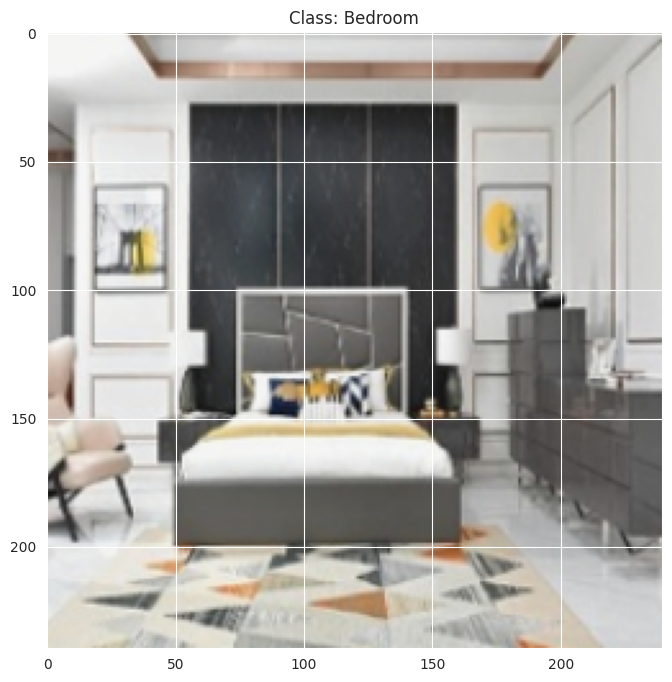

Image shape: (240, 240, 3)
Class: Bedroom (index: 1)


In [3]:
def show_image_from_dataset(dataset_loader, class_names, batch_index=0, image_index=0):
    """
    Display an image from a PyTorch DataLoader.

    Args:
        dataset_loader: PyTorch DataLoader
        class_names: List of class names
        batch_index: Index of the batch to display (default: 0)
        image_index: Index of the image within the batch to display (default: 0)
    """
    # Check if we're getting a DataLoader or a Dataset
    if hasattr(dataset_loader, 'dataset'):
        # It's a DataLoader, get the dataset
        is_dataloader = True
    else:
        # It's already a Dataset
        is_dataloader = False

    try:
        if is_dataloader:
            # Method for DataLoader - we need to iterate through batches
            for i, (images, labels) in enumerate(dataset_loader):
                if i == batch_index:
                    # Found the requested batch
                    if image_index >= len(images):
                        print(f"Error: Image index {image_index} out of range for batch with {len(images)} images")
                        return

                    # Get the specific image and label
                    img = images[image_index]
                    label = labels[image_index]

                    # Display the image
                    display_image(img, label, class_names)
                    return

            # If we get here, the batch wasn't found
            print(f"Error: Batch {batch_index} not found in dataset with {len(dataset_loader)} batches")

        else:
            # Method for direct Dataset access
            # Calculate the absolute index
            absolute_idx = batch_index * 64 + image_index  # Assuming batch size of 64, adjust as needed

            if absolute_idx >= len(dataset_loader):
                print(f"Error: Index {absolute_idx} out of range for dataset with {len(dataset_loader)} images")
                return

            # Get the image and label directly
            img, label = dataset_loader[absolute_idx]
            display_image(img, label, class_names)

    except Exception as e:
        print(f"Error displaying image: {str(e)}")

def display_image(img, label, class_names):
    """Helper function to display and format the image"""
    # Convert tensor to numpy for display
    if isinstance(img, torch.Tensor):
        # If image is a tensor in CxHxW format (PyTorch standard)
        img_np = img.permute(1, 2, 0).cpu().numpy()  # Change to HxWxC format

        # Denormalize if image was normalized
        # Assuming standard normalization with mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean

        # Clip values to valid range
        img_np = np.clip(img_np, 0, 1)
    else:
        img_np = np.array(img)

    # Handle label type
    if isinstance(label, torch.Tensor):
        label_idx = label.item()
    else:
        label_idx = label

    # Get class name
    if label_idx < len(class_names):
        class_name = class_names[label_idx]
    else:
        class_name = f"Unknown (index {label_idx})"

    # Display
    plt.figure(figsize=(8, 8))
    plt.imshow(img_np)
    plt.title(f"Class: {class_name}")
    plt.axis('on')
    plt.show()

    print(f"Image shape: {img_np.shape}")
    print(f"Class: {class_name} (index: {label_idx})")

# Example using a DataLoader
show_image_from_dataset(
    dataset_loader=loaders['train'],  # Your train loader from previous code
    class_names=loaders['classes'],   # Class names from your loader
    batch_index=0,                    # First batch
    image_index=8                     # Fourth image in the batch
)

In [6]:
import os
import numpy as np
import time
import copy
from collections import Counter
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt


def build_model(num_classes, device):
    """
    Build a PyTorch model using EfficientNet B0 as the base model.

    Args:
        num_classes: Number of output classes
        device: The device to put the model on (cuda/cpu)

    Returns:
        model: The complete model
    """
    # Load pretrained EfficientNet B1
    model = models.efficientnet_b1(weights='DEFAULT')

    # Freeze all parameters initially
    for param in model.parameters():
        param.requires_grad = False

    # Replace the classifier
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(256, num_classes)
    )

    # Move model to device
    model = model.to(device)
    return model


def get_class_weights(data_loader):
    """
    Calculate class weights to handle class imbalance.

    Args:
        data_loader: PyTorch DataLoader for training set

    Returns:
        class_weights: Tensor of class weights
    """
    # Extract all labels from the training dataset
    all_labels = []
    for _, labels in data_loader:
        all_labels.extend(labels.numpy())

    # Count class occurrences
    class_counts = Counter(all_labels)
    classes = sorted(class_counts.keys())

    # Use scikit-learn's compute_class_weight
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=all_labels
    )

    # Convert to PyTorch tensor
    class_weights = torch.FloatTensor(class_weights).to('cuda' if torch.cuda.is_available() else 'cpu')
    return class_weights


def train_model(model, dataloaders, criterion, optimizer, scheduler,
                device, num_epochs=25, phase_name="Training"):
    """
    Train a PyTorch model.

    Args:
        model: PyTorch model
        dataloaders: Dictionary containing 'train' and 'val' dataloaders
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        device: Device to train on
        num_epochs: Number of epochs
        phase_name: Name of training phase for logging

    Returns:
        model: Best model based on validation accuracy
        history: Training history
    """
    since = time.time()

    # Deep copy of best model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # History to track metrics
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }

    # Early stopping parameters
    patience = 7
    min_delta = 0.003
    counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'{phase_name} - Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Log current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)
        print(f'Learning Rate: {current_lr:.1e}')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                # Step LR scheduler based on validation performance
                scheduler.step(epoch_loss)

                # Early stopping check
                if epoch_loss < best_val_loss - min_delta:
                    best_val_loss = epoch_loss
                    counter = 0
                    # Save best model weights
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(model.state_dict())
                else:
                    counter += 1
                    if counter >= patience:
                        print(f"Early stopping triggered after {epoch+1} epochs!")
                        # Load best model weights
                        model.load_state_dict(best_model_wts)
                        return model, history

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

def unfreeze_last_n_blocks(model, n=3):
    blocks = list(model.features.children())  # Get all feature blocks
    last_blocks = blocks[-n:]  # Select the last `n` blocks

    for block in last_blocks:
        for param in block.parameters():
            param.requires_grad = True  # Unfreeze the selected blocks

def train_room_classifier(loaders, device=None):
    """
    Complete training pipeline with three phases:
    1. Train only the classifier
    2. Fine-tune last few layers of base model
    3. Fine-tune entire model

    Args:
        loaders: Dictionary containing 'train', 'val', 'test' dataloaders and 'classes'
        device: Device to train on (defaults to GPU if available)

    Returns:
        model: Trained model
        combined_history: Training history from all phases
    """
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Get number of classes and class names
    class_names = loaders['classes']
    num_classes = len(class_names)
    print(f"Training classifier for {num_classes} classes: {class_names}")

    # Create checkpoint directory
    checkpoint_dir = Path("design_classifier_checkpoints")
    checkpoint_dir.mkdir(exist_ok=True)

    # Calculate class weights for handling imbalance
    try:
        class_weights = get_class_weights(loaders['train'])
        print("Class weights:", class_weights)
    except Exception as e:
        print(f"Could not compute class weights: {e}")
        class_weights = None

    # Initialize model
    model = build_model(num_classes, device)

    # Combined history
    combined_history = {}

    # PHASE 1: Train only the classifier layers
    print("\nPHASE 1: Training classifier layers only...")

    # Only parameters of final layer are being optimized
    optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)

    # Define loss function with class weights if available
    if class_weights is not None:
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()

    # Reduce learning rate when a plateau is reached
    scheduler = lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-6
    )

    # Train Phase 1
    model, history1 = train_model(
        model,
        {'train': loaders['train'], 'val': loaders['val']},
        criterion,
        optimizer,
        scheduler,
        device,
        num_epochs=15,
        phase_name="Phase 1"
    )

    # Save Phase 1 checkpoint
    torch.save(model.state_dict(), checkpoint_dir / "phase1_model.pth")
    combined_history['phase1'] = history1

    # PHASE 2: Fine-tune the last few layers
    print("\nPHASE 2: Fine-tuning last few layers...")

    unfreeze_last_n_blocks(model, n=3)

    # Use smaller learning rate for fine-tuning
    optimizer = optim.Adam([
        {'params': [p for n, p in model.named_parameters() if p.requires_grad and 'classifier' not in n], 'lr': 1e-4},
        {'params': model.classifier.parameters(), 'lr': 1e-3}
    ])

    scheduler = lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-6
    )

    # Train Phase 2
    model, history2 = train_model(
        model,
        {'train': loaders['train'], 'val': loaders['val']},
        criterion,
        optimizer,
        scheduler,
        device,
        num_epochs=20,
        phase_name="Phase 2"
    )

    # Save Phase 2 checkpoint
    torch.save(model.state_dict(), checkpoint_dir / "phase2_model.pth")
    combined_history['phase2'] = history2

    # PHASE 3: Fine-tune the entire model
    print("\nPHASE 3: Fine-tuning the entire model...")

    # # Unfreeze all layers
    # for param in model.parameters():
    #     param.requires_grad = True

    unfreeze_last_n_blocks(model, n=4)

    # Use very small learning rate
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    scheduler = lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-7
    )

    # Train Phase 3
    model, history3 = train_model(
        model,
        {'train': loaders['train'], 'val': loaders['val']},
        criterion,
        optimizer,
        scheduler,
        device,
        num_epochs=30,
        phase_name="Phase 3"
    )

    # Save final model
    torch.save(model.state_dict(), "room_classifier_model_pth/V4/room_classifier_final_model.pth")
    torch.save(model, "room_classifier_model_pth/V4/room_classifier_full_model.pth")
    print(f"Model saved to room_classifier_final_model.pth")
    combined_history['phase3'] = history3

    return model, combined_history

torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Train model
model, combined_history = train_room_classifier(loaders, device)

Using device: cuda:0
Training classifier for 5 classes: ['Bathroom', 'Bedroom', 'Dinning', 'Kitchen', 'Livingroom']
Could not compute class weights: The 'classes' parameter of compute_class_weight must be an instance of 'numpy.ndarray'. Got [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)] instead.

PHASE 1: Training classifier layers only...
Phase 1 - Epoch 1/15
----------
Learning Rate: 1.0e-03
train Loss: 1.1080 Acc: 0.5704
val Loss: 0.7048 Acc: 0.7692

Phase 1 - Epoch 2/15
----------
Learning Rate: 1.0e-03
train Loss: 0.8399 Acc: 0.6707
val Loss: 0.6086 Acc: 0.7881

Phase 1 - Epoch 3/15
----------
Learning Rate: 1.0e-03
train Loss: 0.8126 Acc: 0.6839
val Loss: 0.5755 Acc: 0.7758

Phase 1 - Epoch 4/15
----------
Learning Rate: 1.0e-03
train Loss: 0.7915 Acc: 0.6943
val Loss: 0.5714 Acc: 0.7898

Phase 1 - Epoch 5/15
----------
Learning Rate: 1.0e-03
train Loss: 0.7643 Acc: 0.7028
val Loss: 0.5487 Acc: 0.7931

Phase 1 - Epoch 6/15
----------
Learning Rate: 1.0e-03
trai

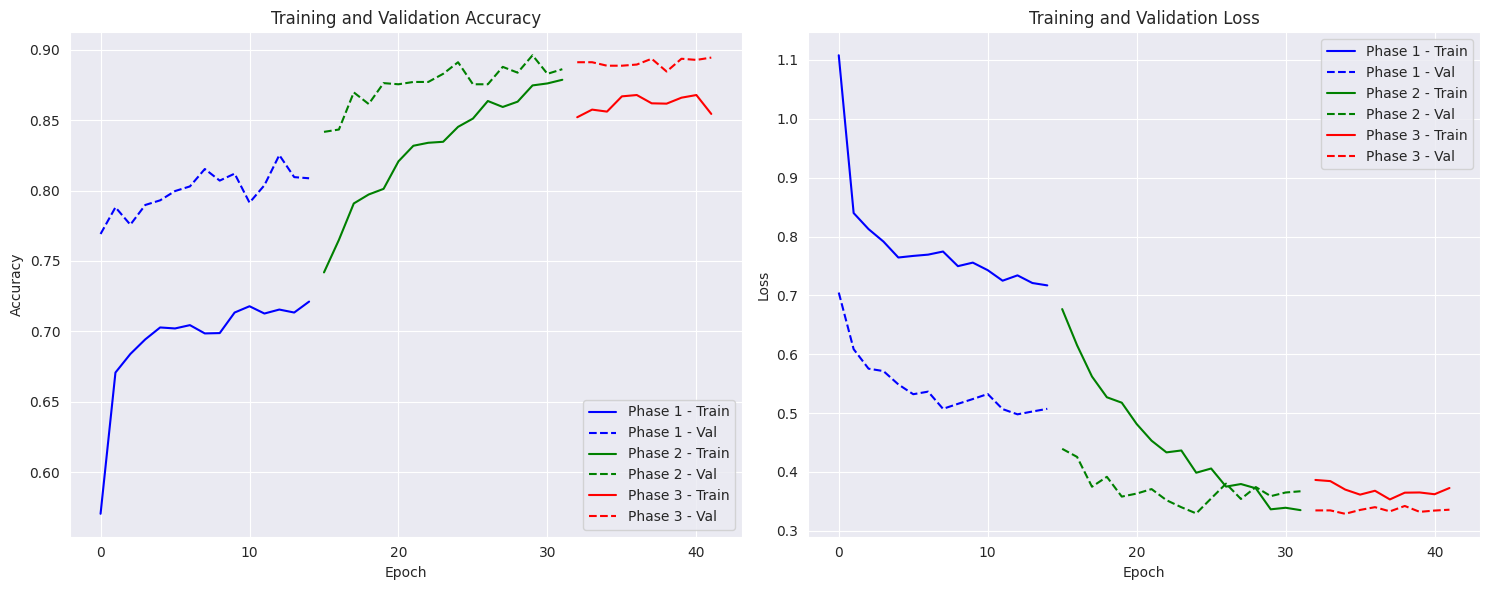

Test Accuracy: 85.83%


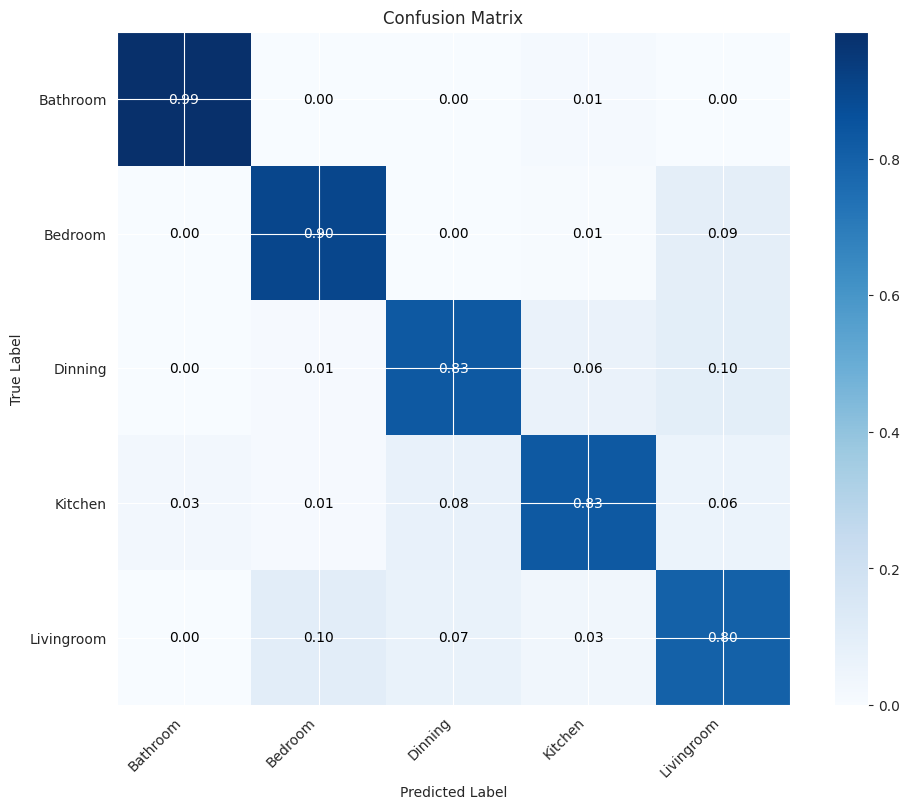

Final test accuracy: 85.83%
Model saved to room_classifier_final_model.pth


In [7]:
def plot_training_history(combined_history):
    """
    Plot the training history from all phases.

    Args:
        combined_history: Dictionary containing training history from all phases
    """
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    colors = ['b', 'g', 'r']
    phases = ['phase1', 'phase2', 'phase3']
    phase_names = ['Phase 1', 'Phase 2', 'Phase 3']

    # Track epoch count for x-axis
    current_epoch = 0

    # Plot training and validation accuracy/loss
    for i, phase in enumerate(phases):
        if phase not in combined_history:
            continue

        history = combined_history[phase]
        epochs = range(current_epoch, current_epoch + len(history['train_acc']))

        # Plot accuracy
        ax1.plot(epochs, history['train_acc'], f'{colors[i]}-',
                 label=f'{phase_names[i]} - Train')
        ax1.plot(epochs, history['val_acc'], f'{colors[i]}--',
                 label=f'{phase_names[i]} - Val')

        # Plot loss
        ax2.plot(epochs, history['train_loss'], f'{colors[i]}-',
                 label=f'{phase_names[i]} - Train')
        ax2.plot(epochs, history['val_loss'], f'{colors[i]}--',
                 label=f'{phase_names[i]} - Val')

        # Update current epoch
        current_epoch += len(history['train_acc'])

    # Set titles and labels
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()


def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test set.

    Args:
        model: Trained PyTorch model
        test_loader: DataLoader for test set
        device: Device to evaluate on

    Returns:
        test_accuracy: Accuracy on test set
    """
    model.eval()
    correct = 0
    total = 0

    # Confusion matrix
    num_classes = len(test_loader.dataset.dataset.dataset.classes)
    confusion_matrix = torch.zeros(num_classes, num_classes)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update confusion matrix
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    # Normalize confusion matrix by row
    confusion_matrix = confusion_matrix / confusion_matrix.sum(1, keepdim=True)

    return accuracy, confusion_matrix


def plot_confusion_matrix(confusion_matrix, class_names):
    """
    Plot the confusion matrix.

    Args:
        confusion_matrix: PyTorch tensor containing confusion matrix
        class_names: List of class names
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(confusion_matrix.numpy(), interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)

    # Add text annotations
    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, f'{confusion_matrix[i, j]:.2f}',
                     ha="center", va="center",
                     color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.show()

# Plot training history
plot_training_history(combined_history)

# Evaluate on test set
accuracy, conf_matrix = evaluate_model(model, loaders['test'], device)

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, loaders['classes'])

print(f"Final test accuracy: {accuracy:.2f}%")